In [1]:
cd D:\Project\diffusiontrack_MOT

D:\Project\diffusiontrack_MOT


In [2]:
import os.path as osp
import os
import torch
import numpy as np
import requests
import glob as gb
import argparse
import cv2
from PIL import Image
import subprocess
# from diffmot import DiffMOT
import argparse
import yaml
from easydict import EasyDict

In [3]:
from Code.Detector.Default_YOLO import Default_YOLO
from Code.Encoder.Motion_Embedding import History_motion_embedding
from Code.Encoder.D2MP import D2MP
from Code.DiffMOT import DiffMOT

from Code.Dataset.PreprocessingData import preprocessing_DanceTrack, preprocessing_DanceTrack1
from Code.Dataset.DiffMOTDataset import DiffMOTDataset, DiffMOTDataLoader

ModuleNotFoundError: No module named 'Code.Encoder.Motion_Embedding'

In [ ]:
# Initialize args with parameters using EasyDict
args = EasyDict({
    "path_yolo": 'yolov8n.pt',
    "path_data": r"Data/DanceTrack",
    "k_frame": 4,
    "batch_size": 4,
    "preprocess_workers": 0,
    "eps": 0.001,
    "lr": 0.0001,
    "data_dir": './outputs',
    "diffnet": 'HMINet',
    "interval": 5,
    "augment": True,
    "encoder_dim": 256,
    "tf_layer": 3,
    "epochs": 3,
    "seed": 123,
    "train": True,
    "val": True,
    "test": True,
    "test_index": 8,
    "eval_mode": False,
    "gpus": [i for i in range(4) if i < torch.cuda.device_count()]
})


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if args.test_index != None:
    from torch.utils.data import Subset

    print(f"Test for {args.test_index} cases")


    # Assuming your dataset is already defined as `train_dataset`
    subset_indices = list(range(args.test_index))  # Get the first 16 indices
    train_dataset = DiffMOTDataset(path=args.path_data + "/train/trackers_gt_t_1", config=args)
    train_subset = Subset(train_dataset, subset_indices)

    # Create a DataLoader with the subset
    train_data_loader = DiffMOTDataLoader(train_subset, config=args)
    val_data_loader = train_data_loader
    test_data_loader = train_data_loader
else:
    if args.train:
        print("Train Dataset: " + args.path_data + "/train")
        train_dataset = DiffMOTDataset(path=args.path_data + "/train/trackers_gt_t_1", config=args)
        train_data_loader = DiffMOTDataLoader(train_dataset, config=args)

    if args.val:
        print("Validation Dataset: " + args.path_data + "/val")
        val_dataset = DiffMOTDataset(path=args.path_data + "/val/trackers_gt_t_1", config=args)
        val_data_loader = DiffMOTDataLoader(val_dataset, config=args)

    if args.test:
        print("Test Dataset: " + args.path_data + "/train2")
        test_dataset = DiffMOTDataset(path=args.path_data + "/train2/trackers_gt_t_1", config=args)
        test_data_loader = DiffMOTDataLoader(test_dataset, config=args)


print("Example dataset:")
train_dataset[0]


Test for 8 cases
21786
Example dataset:


{'cur_gt': array([          0,           7,     0.24479,     0.69769,    0.096875,     0.14167,           1,        1080,        1920,    -0.15478,    0.069725,    -0.18855,    -0.24389,   -0.014795,     0.25148,    0.065826,    -0.25126,     0.10181,     0.27062,    -0.26886,     0.55087,     0.36207,   -0.074506,     -0.2026,
           -0.10009,    -0.24239,   -0.083431,      0.2404,   -0.041867,   -0.091798,    -0.16743,      0.4001,      1.1133,    -0.12544,      1.7962,    0.010487,     0.98165,     0.21596,     0.84733,    -0.21327,    -0.17922,    -0.17279,     -0.2646,   -0.097774,      0.4643,     -0.1425,      0.3174,       0.847,
          -0.011663,    -0.14858,    -0.26796,    -0.26056,     0.05094,    -0.26927,     0.19909,    -0.16911,     0.56699,    -0.14481,   -0.023477,     0.39609,   -0.060917,    -0.13118,    -0.16963,     -0.1676,      1.1674,    0.034968,    0.000172,     0.11149,     -0.1821,      0.8661,     0.68167,       1.591,
           0.079188], dtype=fl

In [ ]:
detector_model = Default_YOLO(args.path_yolo)
encoder_motion = History_motion_embedding().to(device)
D2MP_model = D2MP(config = args, encoder=encoder_motion.to(device)).to(device)
model = DiffMOT(config=args)

d:\anaconda\envs\DiffMOT\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


> Model built!
> Optimizer built!
> Everything built. Have fun :)


**Mode Descriptions**:

- **Eval mode = False**: Used for training models that predict object movement.
    - **Original Model**: `D2MP_model`
    - **New Model**: `UNET3Plus` combined with `StableDiffusion` (by Huy)

- **Eval mode = True**: Used for evaluating performance by combining the trained model with a detector and tracking module.
    - **Online**: For live or real-time scenarios where frames are processed sequentially as they come in.
    - **Offline**: For recorded video where all frames are available beforehand.

**Detector**
   - **Supported Models**:
       - `YOLOX`, `YOLO10`: (x)
       - `YOLO8`          : (v)
   
   - **Function**:
       - **Input**: Every nth frame from the video.
       - **Output**: Bounding box locations of objects detected in the nth frame along with feature representations of each detected object.

**Predict Movement**
   - **Status**: Currently in design and experimentation phase (not fully implemented).
   - **Objective**: To predict the movement of detected objects between frames.

   - **Details**:
       - **Label**: The difference in object location between the nth and (n-1)th frames, with dimensions `(batch size * 4)`.
       - **Input**: Bounding box locations from the (n-interval)th frame to the (n-1)th frame. Each set of boxes has dimensions `(batch size * interval * 8)`.
       - **Output**: Predicted movement (delta location) between the nth frame and (n-1)th frame with dimensions `(batch size * 4)`.

**Re-Identification (Re-Id)**
   - **Objective**: Match objects across frames based on their predicted locations and features.

   - **Details**:
       - **Input**:
           - Bounding box locations for objects detected in the nth frame `(n_objects, 4)`.
           - Feature vectors for each object in the nth frame, provided by the detector `(n_objects, features)`. For YOLO8, feature size is 64.
           - Predicted locations of objects in the nth frame `(n_objects, 4)`.

        - **Output**: Matched object IDs for tracking across frames.

   - **Steps**:
       1. **Handle High-Confidence Detections**:
       2. **Handle Low-Confidence Detections**:
       3. **Match Predicted and Detected Locations to update ID**:
        - Existence object
        - Existence but blurred object
        - NotExistence object
       4. **Update Tracking Information**:

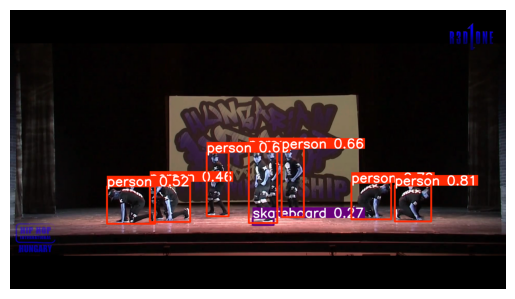

In [59]:
frame_path = r'Data/DanceTrack/train/dancetrack0002\\img1\\00000007.jpg'
result = detector_model.get_object(frame_path)
obj_feats = result.feats
img_result = result.plot()
boxes = result.boxes.data

import matplotlib.pyplot as plt
plt.imshow(img_result)
plt.axis('off')  # Hide axes
plt.show()